https://www.kaggle.com/iafoss/panda-16x128x128-tiles

In [1]:
import os
import cv2
import skimage.io
from tqdm.notebook import tqdm
import zipfile
import numpy as np

import sys
sys.path.append("../utils")
from minimal_image import get_compact

import json

In [2]:
TRAIN = '../input/prostate-cancer-grade-assessment/train_images/'
MASKS = '../input/prostate-cancer-grade-assessment/train_label_masks/'

OUT_TRAIN = '../input/panda-16x128x128-tiles-data/train'
OUT_MASKS = '../input/panda-16x128x128-tiles-data/masks.zip'
sz = 128
N = 16

In [3]:
def tile(img):
    result = []
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                constant_values=255)
    
    h, w = img.shape[:2]
    
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    
    if len(img) < N:
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)

    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    
    img = img[idxs]
    for i in range(len(img)):
        result.append({'img':img[i], 'idx':i})
    
    return result

In [4]:
with open("../input/compact_representation.json", "r") as file:
    compact_representation = json.load(file)

In [5]:
x_tot,x2_tot = [],[]
names = [name[:-10] for name in os.listdir(MASKS)]
for name in tqdm(names):
    key = name + '.tiff'
    img = skimage.io.MultiImage(os.path.join(TRAIN, name + '.tiff'))[-1]

    img = get_compact(img, compact_representation[key])

    tiles = tile(img)
    for t in tiles:
        img, idx = t['img'], t['idx']
        x_tot.append((img/255.0).reshape(-1,3).mean(0))
        x2_tot.append(((img/255.0)**2).reshape(-1,3).mean(0)) 
        #if read with PIL RGB turns into BGR
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(OUT_TRAIN, f'{name}_{idx}.png'), img)

In [6]:
#image stats
img_avr =  np.array(x_tot).mean(0)
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('mean:',img_avr, ', std:', np.sqrt(img_std))

mean: [0.91069921 0.82123866 0.87951198] , std: [0.35856409 0.4960998  0.40166728]


In [7]:
import matplotlib.pyplot as plt

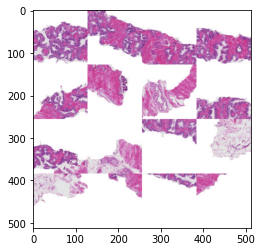

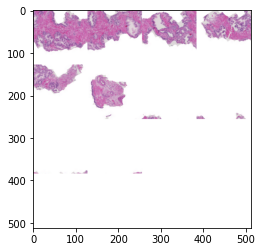

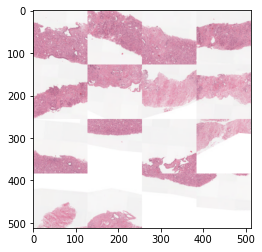

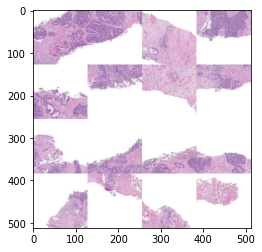

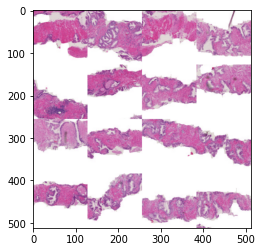

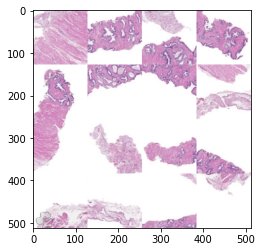

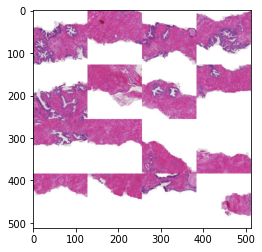

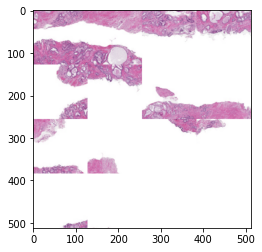

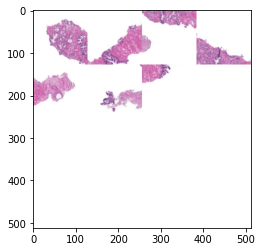

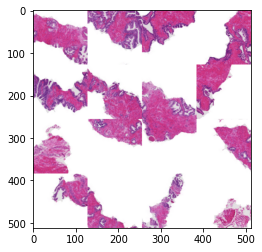

In [9]:
for name in tqdm(names[:10]):
    key = name + '.tiff'
    img = skimage.io.MultiImage(os.path.join(TRAIN, name + '.tiff'))[-1]
    mask = skimage.io.MultiImage(os.path.join(MASKS,name+'_mask.tiff'))[-1]

    img = get_compact(img, compact_representation[key])
    mask = get_compact(mask, compact_representation[key])

    tiles = tile(img)
    
    n = int(np.sqrt(N))
    res_img = np.empty([sz * n, sz * n, 3], dtype=np.uint8)
    for i in range(N):
        t = tiles[i]
        idx = t["idx"]
        x = idx % n
        y = idx // n
        res_img[y*sz:(y + 1)*sz, x*sz:(x+1)*sz] = t["img"]
    plt.figure()
#     res_img = res_img.transpose(0, 1, 2, 3)
#     res_img = res_img.reshape([sz * n, sz * n, 3])
    plt.imshow(res_img)